In [15]:
import os
import glob
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import pyklip.spectra_management as specmanage
import pyklip.fm as fm
import pyklip.instruments.GPI as GPI
import pyklip.fitpsf as fitpsf
import pyklip.fmlib.fmpsf as fmpsf


# Generate the Forward Model

## Generate the instrumental PSF for GPI Data

We will use the satellite spots to generate the instrumental PSF of the data. The output will be a 37x25x25 spectral cube, with each wavelength containing a 25x25 pixel stamp of the instrumental PSF. We will normalize the instrumental PSF to unity

In [9]:
# Read the files first

# grab the files
filelist = glob.glob(os.path.join("..", "tests", "data", "S20131210*distorcorr.fits"))
filelist.sort()
# hopefully there is still 3 filelists
assert(len(filelist) == 3)

# read in data, with a not very aggressive high pass filter just to remove low frequency background
dataset = GPI.GPIData(filelist, highpass=40)

Reading File: ../tests/data/S20131210S0092_spdc_distorcorr.fits
Reading File: ../tests/data/S20131210S0099_spdc_distorcorr.fits
Reading File: ../tests/data/S20131210S0111_spdc_distorcorr.fits


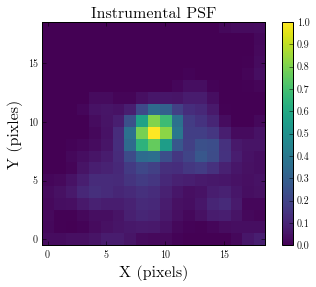

In [23]:
# generate PSF
cubesize=19
dataset.generate_psfs(boxrad=cubesize//2)
dataset.psfs /= (np.mean(dataset.spot_flux.reshape([dataset.spot_flux.shape[0] / 37, 37]), axis=0)[:, None, None])

# Let's plot the instrumental PSF, collapsed in the wavelength dimension
collapsed_psf = np.mean(dataset.psfs, axis=0)

fig = plt.figure()

plt.imshow(collapsed_psf, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.gca().invert_yaxis()
plt.xlabel("X (pixels)", fontsize=16)
plt.ylabel("Y (pixles)", fontsize=16)
plt.colorbar()
plt.title("Instrumental PSF", fontsize=16)


## Initial Estimates of the Position and Spectrum of the Planet

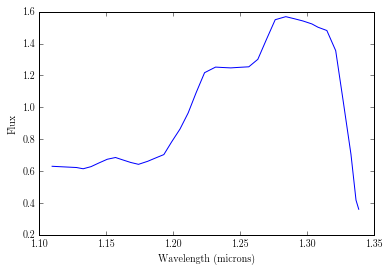

In [18]:
# setup FM guesses
numbasis = np.array([1, 7, 100]) # KL basis cutoffs you want to try
guesssep = 30.1 # estimate of separation in pixels
guesspa = 212.2 # estimate of position angle, in degrees
guessflux = 5e-5 # estimated contrast
dn_per_contrast = dataset.dn_per_contrast # DN/contrast ratio. For GPI, this is dataset.dn_per_contrast

# Let's grab the 1600 K, log(g)=100, no cloud model from the pyklip spectral library
spectra_folder = os.path.dirname(os.path.abspath(specmanage.__file__)) + os.sep + "spectra" + os.sep
spectra_file = spectra_folder + os.sep + "g100ncflx" + os.sep + "t1600g100nc.flx"
# we want each spectra to only have 37 channels (we don't need it to repeat for each file)
unique_wvs = np.unique(dataset.wvs)
guessspec = specmanage.get_planet_spectrum(spectra_file, "J")[1]

# plot the spectrum
plt.plot(unique_wvs, guessspec)
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux")

## Initialize the fmpsf class

This provides the functionality to forward model a planet PSF through KLIP. The warning about the coefficients of the spline that appears when running the following line of code can be safely ignored 

In [20]:
fm_class = fmpsf.FMPlanetPSF(dataset.input.shape, numbasis, guesssep, guesspa, guessflux, dataset.psfs,
                                 np.unique(dataset.wvs), dn_per_contrast, star_spt='A6', wavelengths='J',
                                 spectrallib=[guessspec])

/usr/local/lib/python2.7/dist-packages/scipy/interpolate/fitpack2.py:1004: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=123). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


In [21]:
# PSF subtraction parameters
# You should change these to be suited to your data!
outputdir = "." # where to write the output files
prefix = "betpic-131210-j-fmpsf" # fileprefix for the output files
annulus_bounds = [[guesssep-15, guesssep+15]] # one annulus centered on the planet
subsections = 1 # we are not breaking up the annulus
padding = 0 # we are not padding our zones
movement = 4 # we are using an conservative exclusion criteria of 4 pixels


# run KLIP-FM
fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement)



Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 100.00% of total completed
Closing threadpool
Writing KLIPed Images to directory /home/jwang/GPI/klip/pyklip/examples


/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


# Fitting the Forward Model to the Data